In [1]:
import os
import matplotlib
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
from tqdm.auto import tqdm
import pickle
import time
from nlp_utils import get_cos_sim, add_text_to_image, set_default_figure_params
from quintuplets import QuadrupletId, load_quadruplet, QUINTUPLETS_DATASET_PATH, Quintuplet, visualize_quadruplet, get_splits_ids
import seaborn as sns
# sns.set_theme()
set_default_figure_params()

/home/dcor/roeyron/miniconda3/envs/patchscopes/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/home/dcor/roeyron/miniconda3/envs/patchscopes/lib/python3.10/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [44]:
all_ids = sorted(os.listdir(QUINTUPLETS_DATASET_PATH))

results_dir = '/home/dcor/roeyron/TCIE/results/qard_v4_embeddings_wo_answer_shortly/'
results_fnames = sorted(os.listdir(results_dir))
results_fpaths = [os.path.join(results_dir, fname) for fname in results_fnames]


splits_ids = get_splits_ids()

split_ids_rev = {}
for k, v in split_ids.items():
    for e in v:
        split_ids_rev[e] = k


df = pd.concat([pd.read_pickle(fpath) for fpath in tqdm(results_fpaths)])
df['quintuplet_id'] = df['quintuplet_id'].apply(int)
df['split'] = df.quintuplet_id.apply(lambda i: split_ids_rev[i])
print(len(df))
df.head()

  0%|          | 0/60 [00:00<?, ?it/s]

1800


,hidden_states,input_ids,output_ids,question_type,quintuplet_id,which,image_type,split
0,"[[[0.0746, -0.642, 0.0571, 0.2109, -0.06464, 0...","[1, 733, 16289, 28793, 28705, 32000, 28705, 13...","[1, 733, 16289, 28793, 28705, 32000, 28705, 13...",original,69,gamma_positive,query,train
1,"[[[0.1337, -0.528, 0.08386, 0.10834, -0.2244, ...","[1, 733, 16289, 28793, 28705, 32000, 28705, 13...","[1, 733, 16289, 28793, 28705, 32000, 28705, 13...",original,69,gamma_positive,positive,train
2,"[[[0.12476, -0.5835, 0.2115, 0.2006, -0.1752, ...","[1, 733, 16289, 28793, 28705, 32000, 28705, 13...","[1, 733, 16289, 28793, 28705, 32000, 28705, 13...",original,69,gamma_positive,negative,train
3,"[[[0.0746, -0.642, 0.0571, 0.2109, -0.06464, 0...","[1, 733, 16289, 28793, 28705, 32000, 28705, 13...","[1, 733, 16289, 28793, 28705, 32000, 28705, 13...",general,69,gamma_positive,query,train
4,"[[[0.1337, -0.528, 0.08386, 0.10834, -0.2244, ...","[1, 733, 16289, 28793, 28705, 32000, 28705, 13...","[1, 733, 16289, 28793, 28705, 32000, 28705, 13...",general,69,gamma_positive,positive,train


In [45]:
def get_df_results(query_prompt, search_prompt, split, layer=None):
    assert query_prompt in ['general', 'original']
    assert search_prompt in ['general', 'original']
    i_token = -1
    layers = range(1, 33) if layer is None else [layer]
    
    qd_ids = df[['quintuplet_id', 'which']].drop_duplicates()
    qd_ids = [QuadrupletId(e.quintuplet_id, e.which) for _, e in qd_ids.iterrows()]
    qd_ids = [qd_id for qd_id in qd_ids if qd_id.quintuplet_id in splits_ids[split]]
    ddl_results = defaultdict(list)
    
    for i_layer in layers:
        for qd_id in qd_ids:
            df_qd_query = df[(df.quintuplet_id == qd_id.quintuplet_id) & (df.which == qd_id.which) & (df.question_type == query_prompt)]
            df_qd_serach = df[(df.quintuplet_id == qd_id.quintuplet_id) & (df.which == qd_id.which) & (df.question_type == search_prompt)]
            hs_query = df_qd_query[df_qd_query.image_type == 'query'].iloc[0].hidden_states[i_layer, i_token]
            hs_positive = df_qd_serach[df_qd_serach.image_type == 'positive'].iloc[0].hidden_states[i_layer, i_token]
            hs_negative = df_qd_serach[df_qd_serach.image_type == 'negative'].iloc[0].hidden_states[i_layer, i_token]
    
            sim_p = get_cos_sim(hs_query, hs_positive)
            sim_n = get_cos_sim(hs_query, hs_negative)
            correct = sim_p > sim_n
            
            ddl_results['i_layer'].append(i_layer)
            ddl_results['i_token'].append(i_token)
            ddl_results['correct'].append(correct)
            ddl_results['sim_p'].append(sim_p)
            ddl_results['sin_n'].append(sim_n)
    
    df_results = pd.DataFrame(ddl_results)
    return df_results

In [46]:

def plot_accuracy_per_layer(df_results):
    # Assuming df_results is your DataFrame
    sr = df_results.groupby(by='i_layer')['correct'].agg(['mean', 'sem']).reset_index()
    sr = sr.rename(columns={'mean': 'accuracy', 'sem': 'error'})
    plt.figure()
    sns.set_style("whitegrid")
    ax = sns.lineplot(x='i_layer', y='accuracy', data=sr, marker='o', label='Accuracy')
    plt.fill_between(sr['i_layer'], 
                     sr['accuracy'] - sr['error'], 
                     sr['accuracy'] + sr['error'], 
                     alpha=0.2, 
                     # label='Error margin'
                    )
    best_layer = sr.loc[sr['accuracy'].idxmax(), 'i_layer']
    best_accuracy = sr['accuracy'].max()
    
    plt.scatter([best_layer], [best_accuracy], marker='*', c='green', s=70, zorder=5, label=f'Optimum')
    
    plt.xlabel('Layer')
    plt.ylabel('Accuracy')
    plt.xticks(range(0, len(sr['i_layer'])+1, 2))
    
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

# original question (use the same specific question)

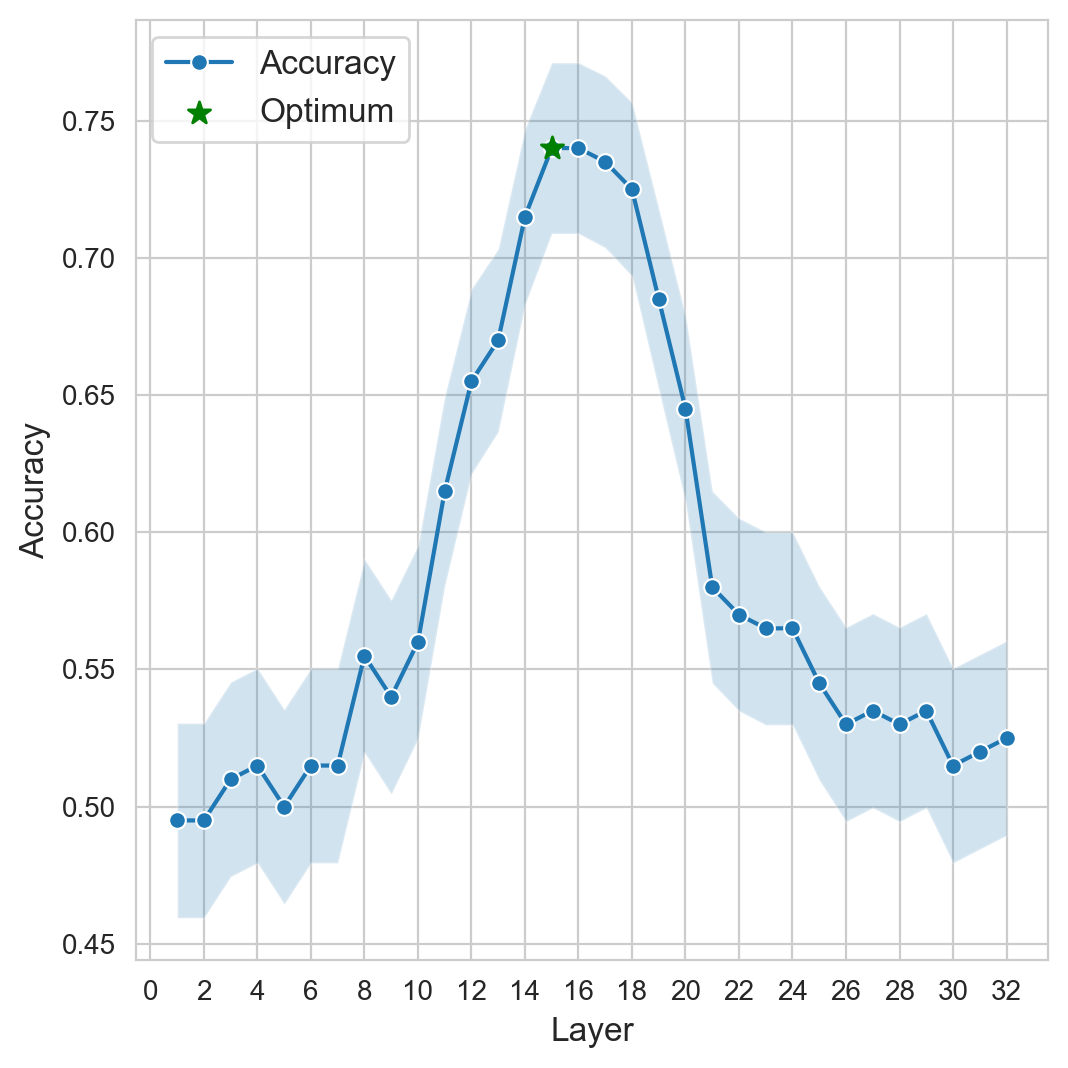

test accuracy 0.77


In [48]:
df_results_orig_orig_train = get_df_results('original', 'original', 'train')
best_layer = df_results_orig_orig_train.groupby('i_layer').mean().correct.argmax()
plot_accuracy_per_layer(df_results_orig_orig_train)
df_results_orig_orig_test = get_df_results('original', 'original', 'test', layer=best_layer)

test_acc = df_results_orig_orig_test[df_results_orig_orig_test.i_layer == best_layer].correct.mean()
print('test accuracy', test_acc)

# use different prompts

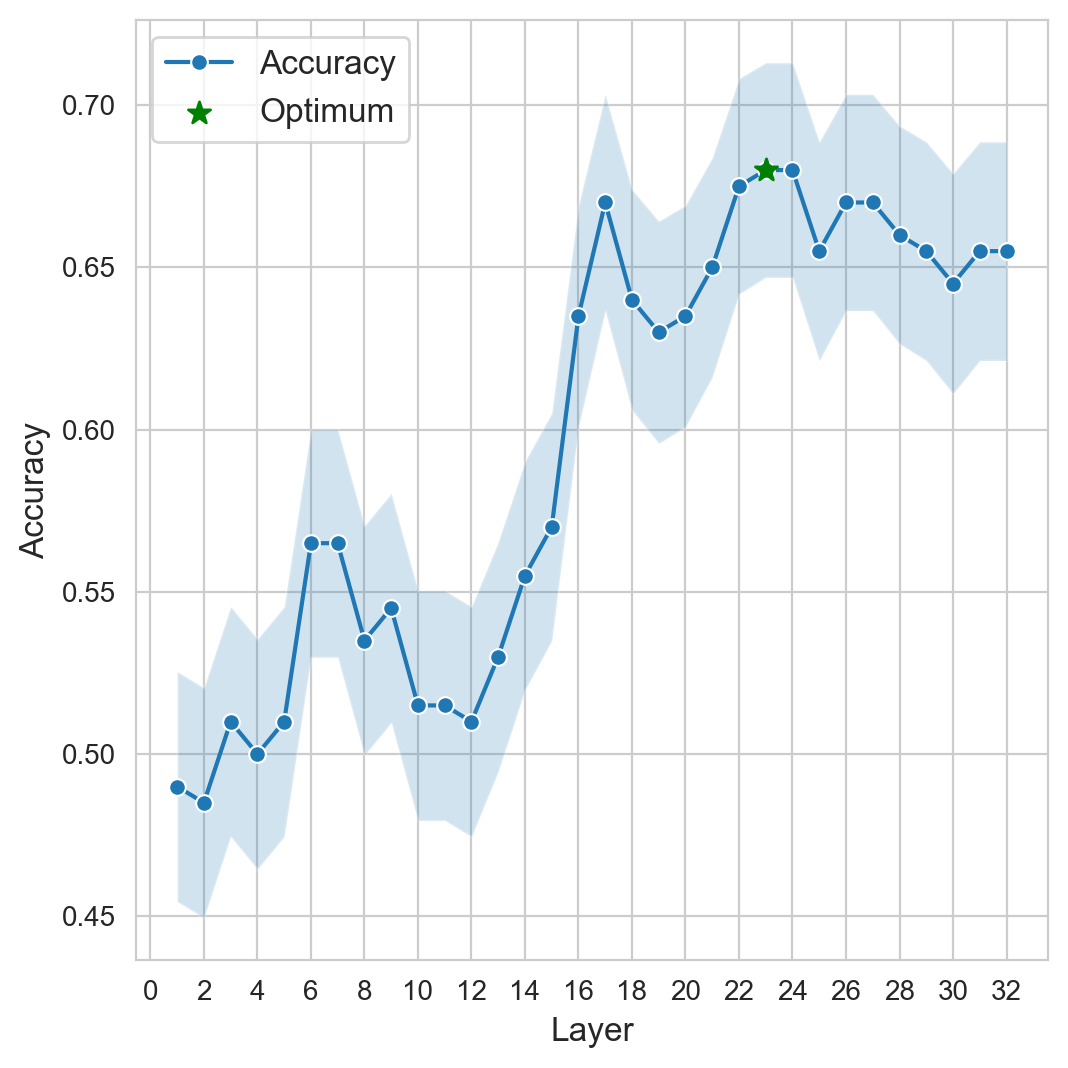

test accuracy 0.66


In [49]:
    df_results_orig_general_train = get_df_results('original', 'general', 'train')
best_layer = df_results_orig_general_train.groupby('i_layer').mean().correct.argmax()
plot_accuracy_per_layer(df_results_orig_general_train)

df_results_orig_general_test = get_df_results('original', 'general', 'test')

test_acc = df_results_orig_general_test[df_results_orig_general_test.i_layer == best_layer].correct.mean()
print('test accuracy', test_acc)

# Visual examination of predicitons 

In [ ]:
i_token = -1

qd_ids = df[['quintuplet_id', 'which']].drop_duplicates()
qd_ids = [QuadrupletId(e.quintuplet_id, e.which) for _, e in qd_ids.iterrows()]
ddl_results = defaultdict(list)

for qd_id in qd_ids[:20]:
    df_qd = df[(df.quintuplet_id == qd_id.quintuplet_id) & (df.which == qd_id.which)]
    # for i_layer in range(0, 33):
    i_layer = best_layer
    hs_query = df_qd[df_qd.image_type == 'query'].iloc[0].hidden_states[i_layer, i_token]
    hs_positive = df_qd[df_qd.image_type == 'positive'].iloc[0].hidden_states[i_layer, i_token]
    hs_negative = df_qd[df_qd.image_type == 'negative'].iloc[0].hidden_states[i_layer, i_token]

    
    sim_p = get_cos_sim(hs_query, hs_positive)
    sim_n = get_cos_sim(hs_query, hs_negative)
    correct = sim_p > sim_n

    print(correct)
    visualize_quadruplet(QUINTUPLETS_DATASET_PATH, qd_id)
        